# Entanglement Negativity Landscapes with Different Temperatures Distributions and Different System Sizes

## 1. Theory

This model is given by a general nearest neightbours free fermionic Hamiltonian with density-density (Hubbard) interactions.
$$
H = h \sum_j^L n_j + \lambda \sum_j^L (c_j^\dagger c_{j+1}+\text{h.c.})  + p \sum_j^L (c_j c_{j+1} + \text{h.c.}) + g \sum_j^L n_j n_{j+1}. \tag{1}
$$
We let the system be under the influence of a bath so, at least axiomatically, the evolution goes via the Lindbland equation
$$
{\displaystyle {\dot {\rho}(t)}=-{i }[H,\rho(t) ]+\sum_{n=1}^L\Gamma _{n}s_n\left(c_n^{\dagger }\rho(t) c_n-{\frac {1}{2}}\left\{c_n c_n^{\dagger },\rho(t) \right\}\right) +\Gamma _{n}(1-s_n)\left(c_n\rho(t) c_n^{\dagger }-{\frac {1}{2}}\left\{c_n^{\dagger }c_n,\rho(t) \right\}\right) \\ \tag{2}
}
$$
where $\Gamma_n$ are the excitation/de-excitation rates and $s_n,(1-s_n)$ temperatures, $s\in [0,1]$. 

Set $p=g=0$ in (1) for the moment. It is easy to see that if $\Gamma_n = \Gamma_l$ and $s_n=s_l$ $\forall l,n$ then ,in momentum space, (2) can be casted as
$$
{\displaystyle {\dot {\rho}(t)}=-{i }\sum_k^L[ \epsilon_k n_k,\rho(t) ]+\sum_{k=1}^L \Gamma s \left(c_k^{\dagger }\rho(t) c_k-{\frac {1}{2}}\left\{c_k c_k^{\dagger },\rho(t) \right\}\right) +\Gamma (1-s)\left(c_k\rho(t) c_k^{\dagger }-{\frac {1}{2}}\left\{c_k^{\dagger }c_k,\rho(t) \right\}\right) \\
}
$$
which admits the unique NESS ansatz
$$
\rho_\infty = \frac{1}{\mathcal{Z}} \exp\left(-\ln \left|\frac{s}{1-s}\right|\sum_k n_k\right),
$$
which is of identical form in real space, of course, 
$$
\rho_\infty = \frac{1}{\mathcal{Z}} \exp\left(-\ln \left|\frac{s}{1-s}\right|\sum_j n_j\right),
$$
completely unentangled in either basis.

If we now let $\lambda=p=g=0$ we can do now even better as our ansatz now commutes with $H$ in real space, so we can keep $\Gamma_n$ and $s_n$ still arbitrary and yield the odd-looking, but expected (unique again) NESS
$$
\rho_\infty = \frac{1}{\mathcal{Z}} \exp\left(-\ln \sum_j \ln \left|\frac{s_j}{1-s_j}\right| n_j\right),
$$
again, completely unentangled in real space (it's still a diagonal matrix).

Even when $\Gamma_n = \Gamma_l$ and $s_n=s_l$ $\forall l,n$ and $g=0$ if $p\neq 0$ things get very complicated due to the Bogoliubov transformation, which forbids us of bringing the entire Lindbland equation in diagonal form (both $H$ and dissipative terms). 

COMMENT ON WHAT HAPPENS WHEN $\Gamma_n = \Gamma_l$ and $s_n=s_l$ $\forall l,n$ if $p\neq 0$ AND $p=0$ BUT $g \neq 0 $.

Surprisingly, even for $p=g=0$, if we allow $\Gamma_n$ and $s_n$ to take different values at different lattice sites the NESS can become entangled. This is a physically relevant scenario, as one expects real materials in nature to be coupled to the (inevitable) bath slightly differently at each point in space. Unfortunately, for the moment, we havent been able to find the NESS of (2) even for this scenario. However, we can simulate them all for suficiently small system sizes.



## 2. Simulation

The following sections of code perform numerically the above. Some imports and operators definitions first.

In [1]:
%matplotlib notebook
from IPython.display import Image
from qutip import *
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.linalg import sqrtm
from tqdm import tqdm
from IPython.display import clear_output

def Id(L):
    op_list = []
    for i in range(L):
        op_list.append(qeye(2))
    op = Qobj(tensor(op_list))
    return op

def sigma_z(k,L):
    op_list = []
    if k<=L-1 and k>=0:
        for i in range(L):
            if i==k:
                op_list.append(sigmaz())
            else:
                op_list.append(qeye(2))
        op = Qobj(tensor(op_list))
        return op

    else:
        raise ValueError("Index out of range: Operator sigma_z_"+str(k)+" may not be casted in a system with "+str(L)+" spins. By convention first spin is labeled as 0.")

def c(k,L):
    if k<=L-1 and k>=0:
        op_list = []
        for i in range(L):
            if i==k:
                op_list.append(destroy(2))
            else:
                op_list.append(qeye(2))
        aux = Qobj(tensor(op_list))
        phase = Qobj(tensor([qeye(2)]*(L)))
        for i in range(0,k):
            phase = phase*sigma_z(i,L)
        op = phase*aux
        return op

    else:
        raise ValueError("Index out of range: Operator c_"+str(k)+" may not be casted in a system with "+str(L)+" spins. By convention first spin is labeled as 0.")

Usefull standard error method for later...

In [2]:
def stnd_err(data):
    tot = sum(data)
    avg = tot/len(data)
    tot = 0
    for val in data:
        tot += (val - avg)**2
    sigma = np.sqrt(tot/len(data))
    return sigma

Defining the Hamiltonian in `QuTip`. Here `t` is $\lambda$ as defined in (1) above.

In [3]:
def Hamiltonian(L,h,t,p,g):
    aux = Id(L)-Id(L)
    for j in range(L-1):   #when we dont have to worry about bc
        aux += h*c(j,L).dag()*c(j,L)     #site energy
        aux += t*(c(j,L).dag()*c(j+1,L)+c(j+1,L).dag()*c(j,L))  #hopping
        aux += p*(c(j,L)*c(j+1,L)+c(j+1,L).dag()*c(j,L).dag())  #BSC terms
        aux += g*(c(j,L).dag()*c(j,L)*c(j+1,L).dag()*c(j+1,L))  #density-density
    
    #bc terms
    aux += h*c(L-1,L).dag()*c(L-1,L)     #site energy
    aux += t*(c(L-1,L).dag()*c(0,L)+c(0,L).dag()*c(L-1,L))  #hopping
    aux += p*(c(0,L)*c(L-1,L)+c(L-1,L).dag()*c(0,L).dag())  #BSC terms
    aux += g*(c(L-1,L).dag()*c(L-1,L)*c(0,L).dag()*c(0,L))  #density-density
    
    return aux

Method for calculating the negativity of a given density matrix `dm` in a system of `L` sites within a (possible) subsystem `AB` with bipartition given by `A`. What a mouthful.

In [4]:
def E_N_by_L(L,dm,AB,A):
    if len(AB)/(L) < 1:
        rho_ab = (dm).ptrace(sel = AB,sparse=False)
    if len(AB)/(L) == 1:
        rho_ab = Qobj(tensor([Qobj(np.zeros((2,2)))]*(L)))
        rho_ab += dm  #v*v.dag()
    elif len(AB)/(L) > 1:
        raise ValueError("Input error: partial trace must take a subsystem NOT larger than system.")

    rho_p = partial_transpose(rho_ab,A) #hand checked for 8*8 matrix

    del(rho_ab)
    lam = rho_p.eigenenergies()
    del(rho_p)
    lam_neg_sum = 0.0
    for r in range(len(lam)):
        lam_neg_sum += 0.5*(abs(lam[r])-lam[r])
    # print(lam_neg_sum)
    log_neg = np.log(2*lam_neg_sum+1)
    return np.real(log_neg/(L))

This method combines the previous two, feeding $H$ into the the Lindbland equation where the temperatures are drawn from a symmetric Beta distribution, controlled by parameter `beta_param`. This method returns the entanglement negativity by $L$ of the NESS in one single run with the imputed parameters.

In [5]:
def rand_temp_NESS_neg(L,h,t,p,g,gamma,beta_param):
    
    H = Hamiltonian(L,h,t,p,g)

    s = [np.random.beta(beta_param, beta_param, size=None) for i in range(L)];
    
    c_ops = []
    for j in range(L):
        c_ops.extend((gamma*s[j]*c(j,L),gamma*(1-s[j])*c(j,L).dag()))
    
    rho_ness = steadystate(H, c_ops, method="iterative-gmres",use_precond=False,sparse=False)

    sys_list = [i for i in range(L)]
    sys_sel = [0]*(L//2)+[1]*(L//2)
    return E_N_by_L(L, rho_ness, sys_list, sys_sel)
    
# print(rand_temp_NESS_neg(2,0,10,0,0,10,0.01))

0.10086129926126587


# Entanglement Negativity Landscapes with Beta Distributed Temperatures:
## $\max \mathcal{E}(\rho_\infty)$ for different system sizes
## L=2

100%|██████████| 30/30 [16:15<00:00, 32.53s/it]


<IPython.core.display.Javascript object>


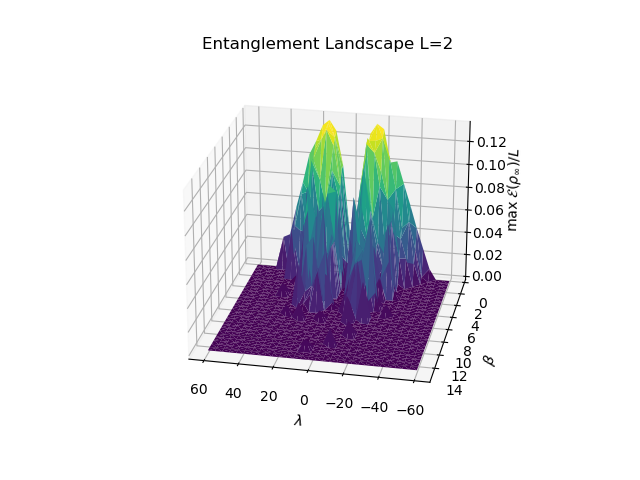

In [20]:
L = 2
gamma = 10

lamb_steps = 30
runs_per_beta = 40
beta_steps = 30

neg_ls = []
lamb_ls = []
beta_ls = []

for beta in tqdm(np.linspace(0,15,beta_steps)):
    for lamb in np.linspace(-60,60,lamb_steps):
        aux_ls = []
        try:
            for i in range(runs_per_beta):
                aux_ls.append(rand_temp_NESS_neg(L,0,lamb,0,0,gamma,beta))
            neg_ls.append(max(aux_ls))
            lamb_ls.append(lamb)
            beta_ls.append(beta)
        except:
            pass

#PLOT IT
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\max \ \mathcal{E}(\rho_\infty)/L$');
ax.set_title('Entanglement Landscape L='+str(L));
# ax.scatter(x,y,z,c=z, cmap='viridis');
ax.plot_trisurf(lamb_ls,beta_ls,neg_ls, cmap='viridis');

## L = 4

100%|██████████| 30/30 [41:18<00:00, 82.63s/it]


<IPython.core.display.Javascript object>


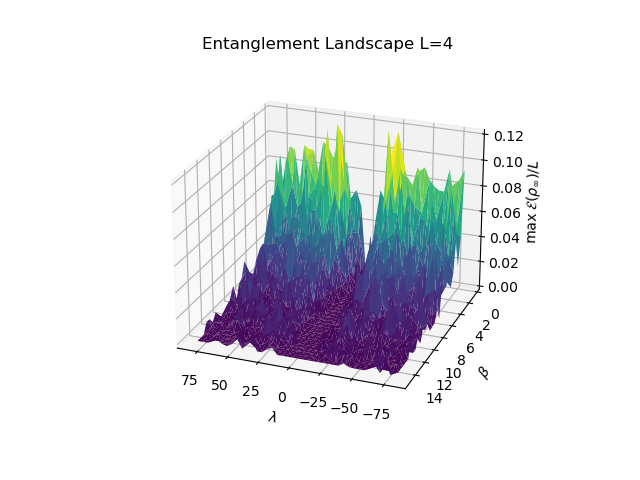

In [18]:
L = 4
gamma = 10

lamb_steps = 40
runs_per_beta = 20
beta_steps = 30

neg_ls = []
lamb_ls = []
beta_ls = []

for beta in tqdm(np.linspace(0,15,beta_steps)):
    for lamb in np.linspace(-80,80,lamb_steps):
        aux_ls = []
        try:
            for i in range(runs_per_beta):
                aux_ls.append(rand_temp_NESS_neg(L,0,lamb,0,0,gamma,beta))
            neg_ls.append(max(aux_ls))
            lamb_ls.append(lamb)
            beta_ls.append(beta)
        except:
            pass

#PLOT IT
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\max \ \mathcal{E}(\rho_\infty)/L$');
ax.set_title('Entanglement Landscape L='+str(L));
# ax.scatter(x,y,z,c=z, cmap='viridis');
ax.plot_trisurf(lamb_ls,beta_ls,neg_ls, cmap='viridis');

## L = 6

In [ ]:
L = 4
gamma = 10

lamb_steps = 40
runs_per_beta = 20
beta_steps = 30

neg_ls = []
lamb_ls = []
beta_ls = []

for beta in tqdm(np.linspace(0,15,beta_steps)):
    for lamb in np.linspace(-80,80,lamb_steps):
        aux_ls = []
        try:
            for i in range(runs_per_beta):
                aux_ls.append(rand_temp_NESS_neg(L,0,lamb,0,0,gamma,beta))
            neg_ls.append(max(aux_ls))
            lamb_ls.append(lamb)
            beta_ls.append(beta)
        except:
            pass

#PLOT IT
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\max \ \mathcal{E}(\rho_\infty)/L$');
ax.set_title('Entanglement Landscape L='+str(L));
# ax.scatter(x,y,z,c=z, cmap='viridis');
ax.plot_trisurf(lamb_ls,beta_ls,neg_ls, cmap='viridis');